In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

初始化神经网络参数 

In [17]:
def get_params(vocab_size, num_hiddens, device):
    # 神经网络的输入和输出的维度都是词汇表的大小
    num_inputs = num_outputs = vocab_size
    # 初始化权重参数
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    # 批量处理更新门、重置门和候选隐藏层参数
    def three():
        return (normal((num_inputs, num_hiddens)),
               normal((num_hiddens, num_hiddens)),
               torch.zeros(num_hiddens, device=device))
    # 更新门参数
    W_xz, W_hz, b_z = three()
    # 重置门参数
    W_xr, W_hr, b_r = three()
    # 候选隐状态参数
    W_xh, W_hh, b_h = three()
    # 输出层
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    
    return params

初始化隐状态

In [18]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

定义门控循环单元模型

In [31]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        # 更新门
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        # 重置门
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        # 候选隐状态
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        # 真正的隐状态
        H = Z * H + (1 - Z) * H_tilda
        # 输出层
        Y = H @ W_hq + b_q
        outputs.append(Y)
    
    return torch.cat(outputs, dim=0), (H,) # 为了方便计算损失，将outputs沿着第一个维度进行拼接，最终输出

为了方便理解torch.cat()，现给出以下例子

In [15]:
a1 = torch.tensor([[1,2],[3,4]])
a2 = torch.tensor([[5,6],[7,8]])

a3 = torch.cat((a1,a2),dim=0)
a3, a3.shape

(tensor([[1, 2],
         [3, 4],
         [5, 6],
         [7, 8]]),
 torch.Size([4, 2]))

由以上例子可以看出，拼接后原张量中的矩阵并未被破坏，仍旧为二维矩阵，只是按行的顺序进行拼接，拼接后的长度改变了，变为了2* 2=4。</br>
因此，outputs沿着第一个维度进行拼接后仍旧为一个二维矩阵，长度则变为批量大小*时间步长

训练部分

perplexity 1.1, 14834.1 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filb 
traveller any his erust no mathematical society only a mont


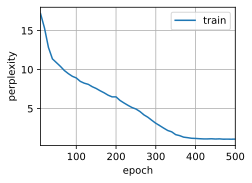

In [32]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params, init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

简洁实现

perplexity 1.0, 161281.3 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


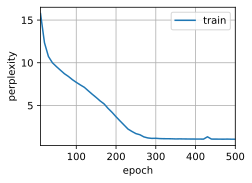

In [33]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)